In [2]:
#The packages needed are imported
import fastf1 as ff1
from fastf1 import plotting
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache')

# Setup plotting
plotting.setup_mpl()

c:\Users\lucam\anaconda3\envs\myenv_f1\lib\site-packages\fastf1\plotting\_plotting.py:90: FutureWarning: FastF1 will no longer silently modify the default Matplotlib colors in the future.
To remove this warning, explicitly set `color_scheme=None` or `color_scheme='fastf1'` when calling `.setup_mpl()`.
  warnings.warn(
c:\Users\lucam\anaconda3\envs\myenv_f1\lib\site-packages\fastf1\plotting\_plotting.py:98: FutureWarning: FastF1 will stop modifying the default Matplotlib settings in the future.
To opt-in to the new behaviour and remove this warning, explicitly set `misc_mpl_mods=False` when calling `.setup_mpl()`.
  warnings.warn(


In [9]:
# We choose the session and load it
session = ff1.get_session(2022, 'Australia', 'Q')
session.load()

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            IN

In [10]:
# We choose the driver and obtain his best lap
driver = 'VER'
fastest_driver = session.laps.pick_drivers(driver).pick_fastest()
telemetry_driver = fastest_driver.get_telemetry().add_distance()

In [11]:
v = telemetry_driver['Speed'] / 3.6    # Speed in m/s
time_float = telemetry_driver['Time'] / np.timedelta64(1, 's')    # Time as a float variable

# We calculate the longitudinal acceleration and filter it
ax = np.gradient(v)/np.gradient(time_float)
ax_smooth = np.convolve(ax, np.ones((3,))/3, mode = 'same')

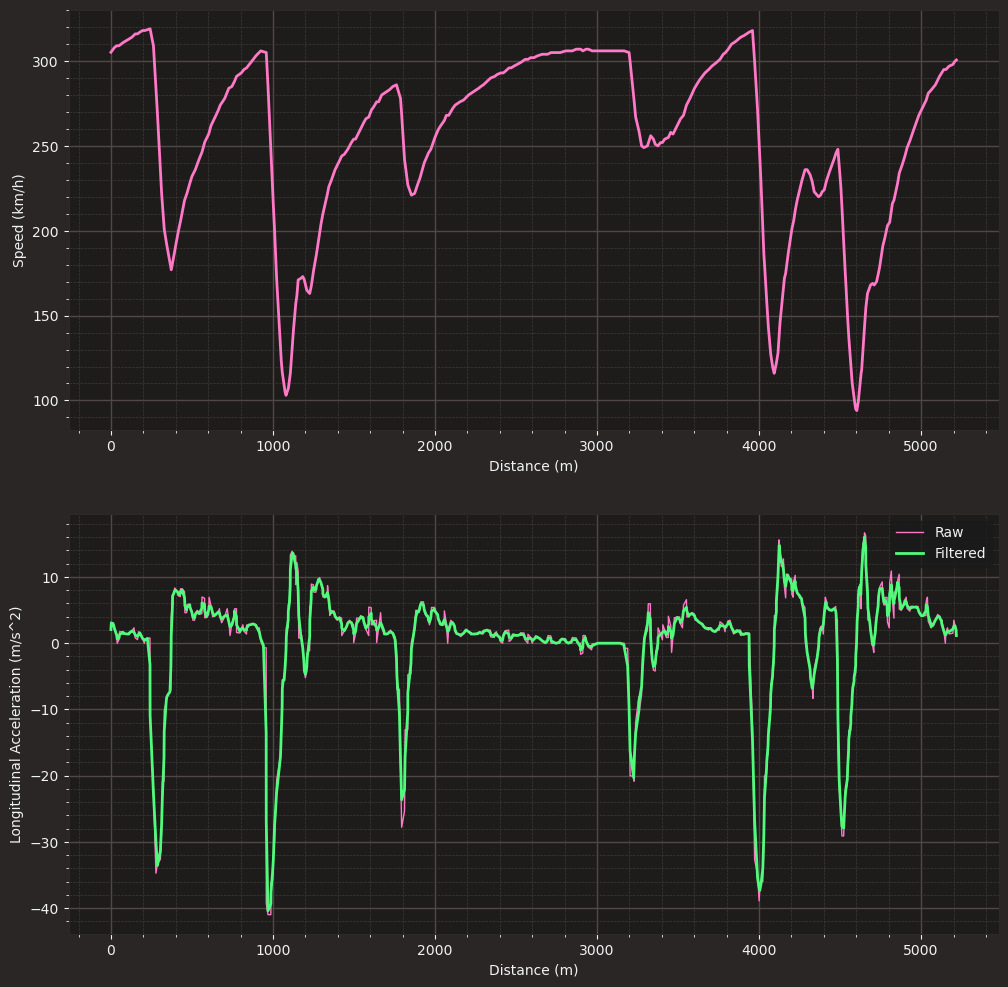

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax, linewidth = 1, label = 'Raw')
axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2, label = 'Filtered')
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")
axes[1].legend()

In [13]:
# I Model: Static Weight Only

m = 798    #kg
g = 9.81

staticWeightTot = m*g

fractionWeightFront = 0.46

staticWeightFront = fractionWeightFront*staticWeightTot
staticWeightRear  = staticWeightTot - staticWeightFront

# The static weights are converted to a (constant) time signal 
loadFront_staticModel = [staticWeightFront] * len(telemetry_driver['Distance'])
loadRear_staticModel  = [staticWeightRear]  * len(telemetry_driver['Distance'])

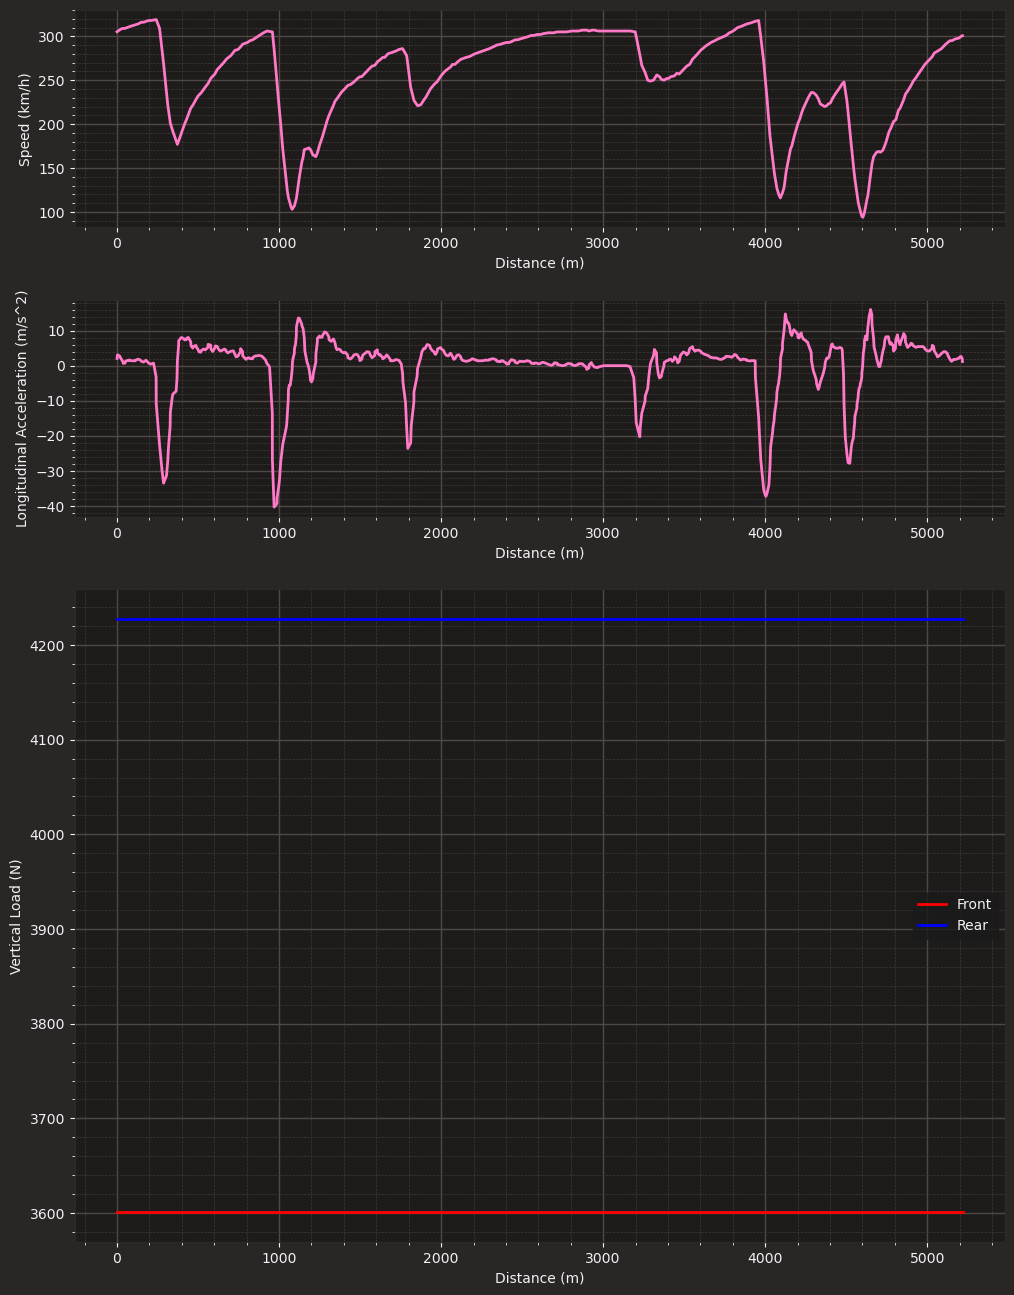

In [14]:
plot_ratios = [1, 1, 3]

fig, axes = plt.subplots(3, 1, figsize=(12, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [12]:
# II Model: Inertial Load Transfer added
CoGheight = 0.25   #m
wheelbase = 3.6    #m

deltaLoad = -CoGheight/wheelbase*m*ax_smooth    #Positive Longitudinal Acceleration -> Load shifts to the rear axle (deltaLoad < 0)

loadFront_loadTransferModel = staticWeightFront + deltaLoad
loadRear_loadTransferModel  = staticWeightRear  - deltaLoad

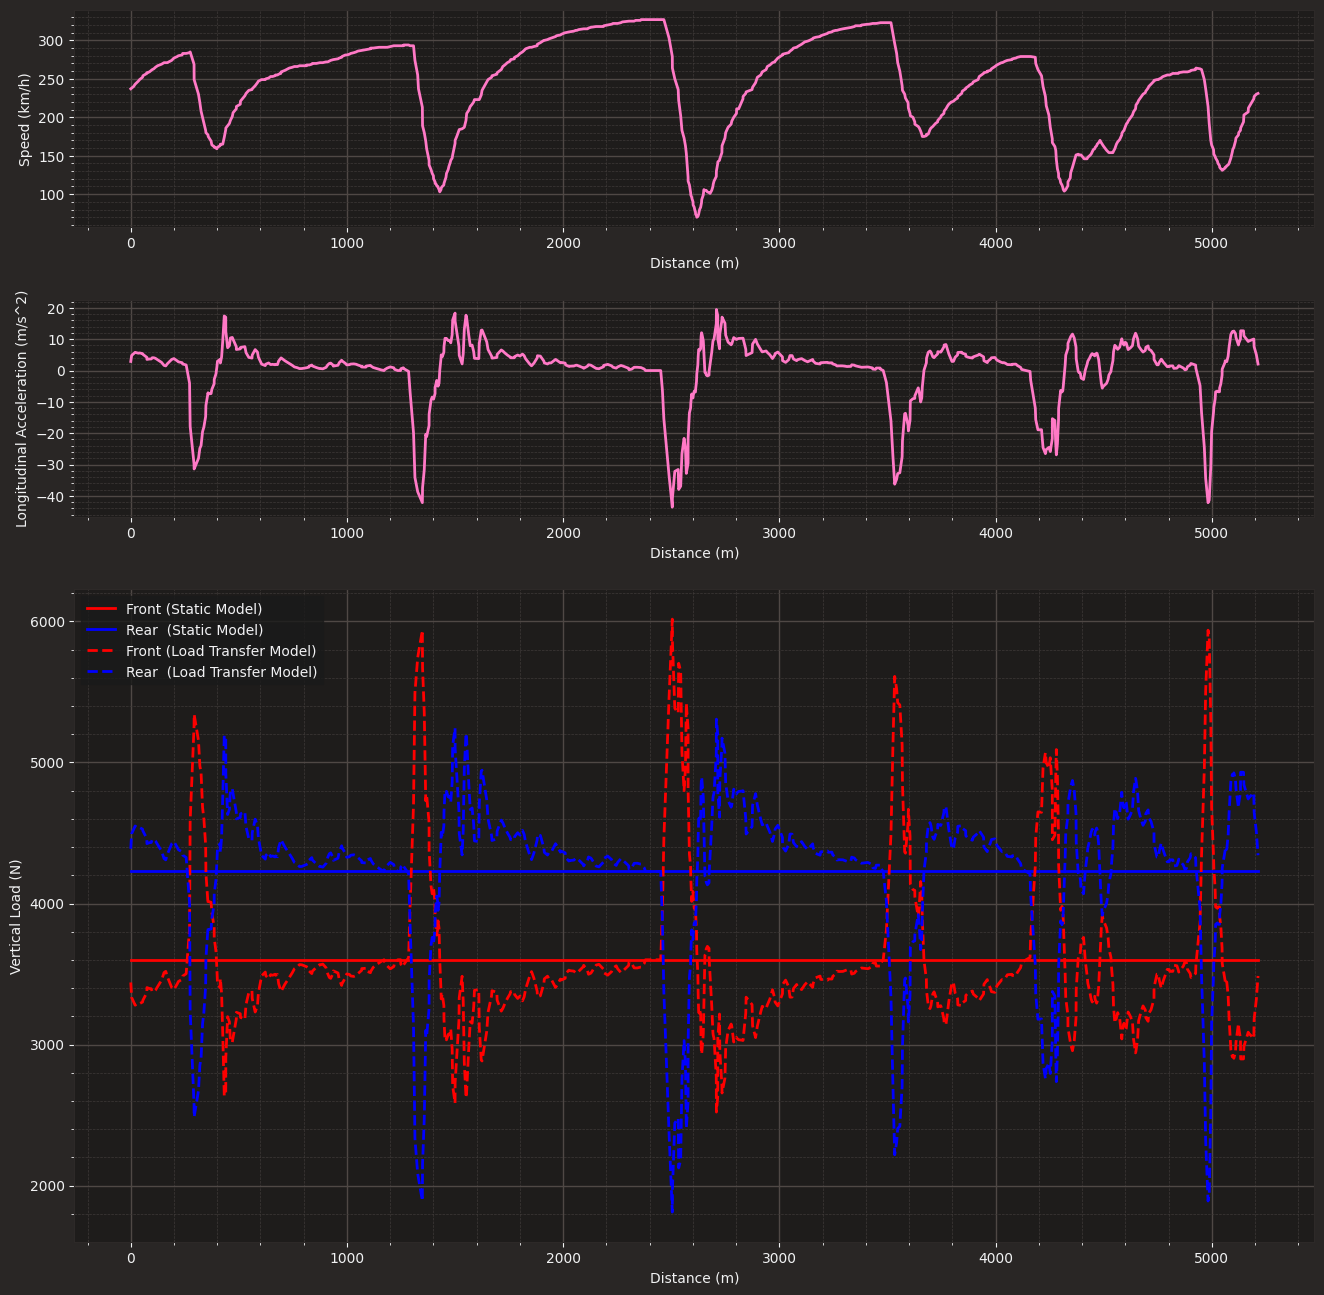

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear  (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferModel, '--r', linewidth = 2, label = 'Front (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferModel, '--b',  linewidth = 2, label = 'Rear  (Load Transfer Model)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [14]:
# III Model: the effect of drag and downforce are added

rho = 1.225
CdA = 1.7               #Drag Coefficient * Frontal Area
efficiency = 3.7
ClA = efficiency*CdA    #Downforce Coefficient * Frontal Area

dragHeight = 0.5 #Height at which the drag force is applied

# We compute the drag and downforce
dragForce = 0.5*CdA*rho*np.square(v)
downForce = 0.5*ClA*rho*np.square(v)

fractionDownforceFront = 0.4    # Front downforce as a fraction of the total downforce (Aero balance)

downForceFront = fractionDownforceFront*downForce
downForceRear = (1 - fractionDownforceFront)*downForce

deltaLoadbyDrag = - dragHeight/wheelbase*dragForce    #Always negative: the drag shifts the load from the front to the rear!

loadFront_loadTransferAeroModel = loadFront_loadTransferModel + downForceFront + deltaLoadbyDrag
loadRear_loadTransferAeroModel  = loadRear_loadTransferModel  + downForceRear  - deltaLoadbyDrag

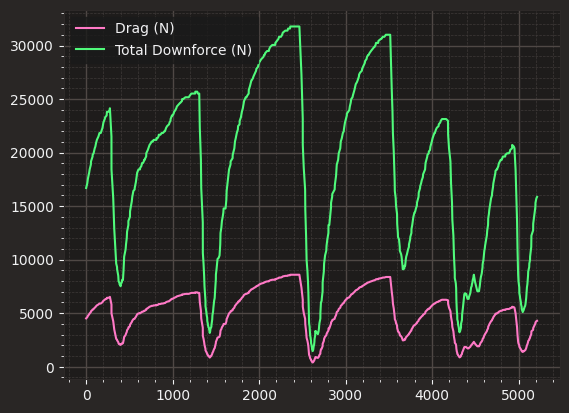

In [15]:
fig, axes = plt.subplots(1)
plt.plot(telemetry_driver['Distance'], dragForce, label = 'Drag (N)')
plt.plot(telemetry_driver['Distance'], downForce, label = 'Total Downforce (N)')
plt.legend()

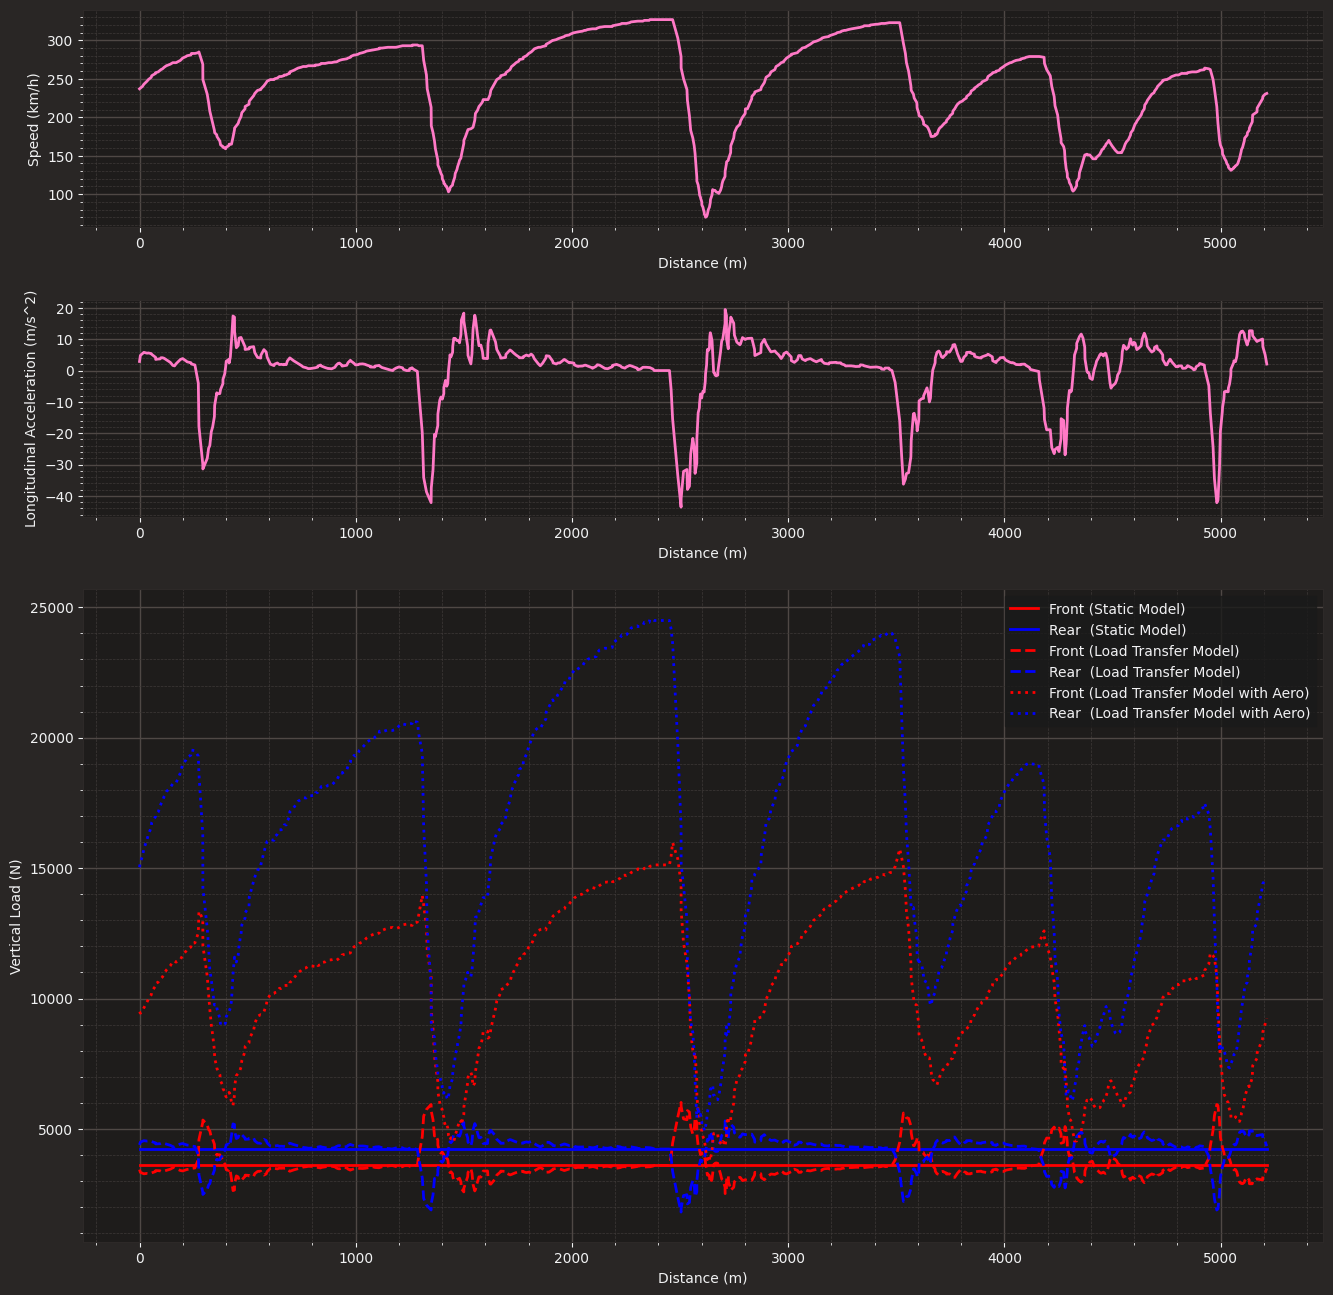

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_staticModel, 'r', linewidth = 2, label = 'Front (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_staticModel, 'b',  linewidth = 2, label = 'Rear  (Static Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferModel, '--r', linewidth = 2, label = 'Front (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferModel, '--b',  linewidth = 2, label = 'Rear  (Load Transfer Model)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel, ':r', linewidth = 2, label = 'Front (Load Transfer Model with Aero)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel, ':b',  linewidth = 2, label = 'Rear  (Load Transfer Model with Aero)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()

In [17]:
def computeLoads(v, ax_smooth, m, fractionWeightFront, CoGheight, wheelbase, CdA, ClA, dragHeight, fractionDownforceFront):

    staticWeightTot = m*g

    staticWeightFront = fractionWeightFront*staticWeightTot
    staticWeightRear = (1 - fractionWeightFront)*staticWeightTot

    # The static weights are converted to a (constant) time signal 
    loadFront_staticModel = [staticWeightFront] * len(v)
    loadRear_staticModel  = [staticWeightRear]  * len(v)
    
    
    deltaLoad = -CoGheight/wheelbase*m*ax_smooth    #Positive Longitudinal Acceleration -> Load shifts to the rear axle (deltaLoad < 0)

    loadFront_loadTransferModel = staticWeightFront + deltaLoad
    loadRear_loadTransferModel  = staticWeightRear  - deltaLoad
    
    dragForce = 0.5*CdA*rho*np.square(v)
    downForce = 0.5*ClA*rho*np.square(v)

    downForceFront = fractionDownforceFront*downForce
    downForceRear = (1 - fractionDownforceFront)*downForce

    deltaLoadbyDrag = - dragHeight/wheelbase*dragForce    #Always negative: the drag shifts the load from the front to the rear!

    loadFront_loadTransferAeroModel = loadFront_loadTransferModel + downForceFront + deltaLoadbyDrag
    loadRear_loadTransferAeroModel  = loadRear_loadTransferModel  + downForceRear  - deltaLoadbyDrag
    
    return(loadFront_loadTransferAeroModel, loadRear_loadTransferAeroModel)

In [18]:
loadFront_loadTransferAeroModel_default, loadRear_loadTransferAeroModel_default =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m,
                                                                                                fractionWeightFront,
                                                                                                CoGheight,
                                                                                                wheelbase,
                                                                                                CdA,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)


loadFront_loadTransferAeroModel_higherMass, loadRear_loadTransferAeroModel_higherMass =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m + 100,
                                                                                                fractionWeightFront,
                                                                                                CoGheight,
                                                                                                wheelbase,
                                                                                                CdA,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)

loadFront_loadTransferAeroModel_higherDrag, loadRear_loadTransferAeroModel_higherDrag =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m,
                                                                                                fractionWeightFront,
                                                                                                CoGheight,
                                                                                                wheelbase,
                                                                                                CdA*1.2,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)

loadFront_loadTransferAeroModel_higherCoG, loadRear_loadTransferAeroModel_higherCoG =  computeLoads(v,
                                                                                                ax_smooth,
                                                                                                m,
                                                                                                fractionWeightFront,
                                                                                                CoGheight*1.2,
                                                                                                wheelbase,
                                                                                                CdA,
                                                                                                ClA,
                                                                                                dragHeight,
                                                                                                fractionDownforceFront)

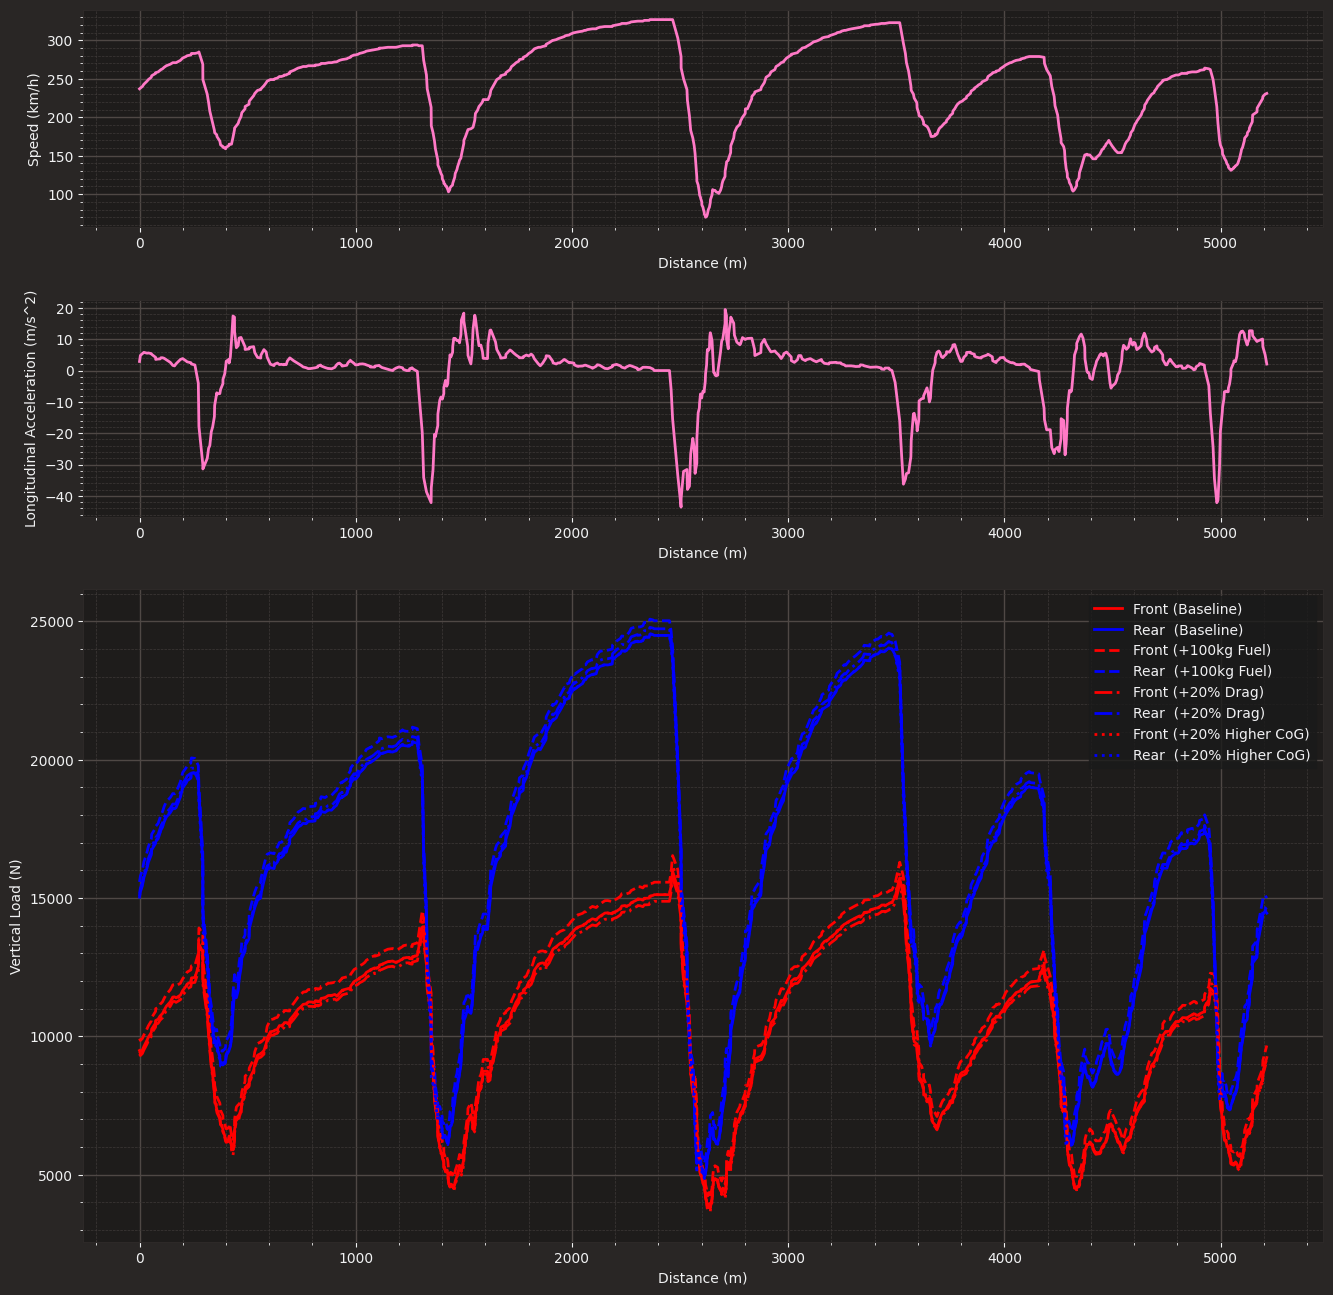

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(16, 16), gridspec_kw={'height_ratios': plot_ratios})
axes[0].plot(telemetry_driver['Distance'], telemetry_driver['Speed'], linewidth = 2)
axes[0].set(xlabel = "Distance (m)", ylabel = "Speed (km/h)")

axes[1].plot(telemetry_driver['Distance'], ax_smooth, linewidth = 2)
axes[1].set(xlabel = "Distance (m)", ylabel = "Longitudinal Acceleration (m/s^2)")

axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_default, 'r',      linewidth = 2, label = 'Front (Baseline)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_default, 'b',       linewidth = 2, label = 'Rear  (Baseline)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_higherMass, '--r', linewidth = 2, label = 'Front (+100kg Fuel)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_higherMass, '--b',  linewidth = 2, label = 'Rear  (+100kg Fuel)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_higherDrag, '-.r', linewidth = 2, label = 'Front (+20% Drag)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_higherDrag, '-.b',  linewidth = 2, label = 'Rear  (+20% Drag)')
axes[2].plot(telemetry_driver['Distance'], loadFront_loadTransferAeroModel_higherCoG, ':r',   linewidth = 2, label = 'Front (+20% Higher CoG)')
axes[2].plot(telemetry_driver['Distance'], loadRear_loadTransferAeroModel_higherCoG,  ':b',   linewidth = 2, label = 'Rear  (+20% Higher CoG)')
axes[2].set(xlabel = "Distance (m)", ylabel = "Vertical Load (N)")
axes[2].legend()